### ANÁLISIS DE SERIES DE TIEMPO (VARIACIÓN DE VALOR DE DIFERENTES MONEDAS)

Considerando un dataset extraído de la api "oanda", que contiene el histórico de la variación por hora del valor de diferentes pares de monedas (EUR-USD, AUD-USD, etc), se propone lo siguiente: 

* Desarrollar un modelo ARIMA que permita predecir el precio de las monedas en días futuros (forecasting). 
sólo para una moneda por ejemplo, Euro - Dólar.



* Desarrollar un modelo ARMA que permita predecir el precio de las monedas en días futuros (forecasting). 

* Desarrollar un modelo de clasificación para determinar regímenes de mercado.  

# Hacer un GridSearch

## 1. Lectura del Dataframe 

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
import os
import math 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
datos = pd.read_csv(r'AUD_USD_H1.csv',index_col= 'time')
print(f'El dataframe que se construye con las variaciones de cotización de moneda está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

datos.head(5)

El dataframe que se construye con las variaciones de cotización de moneda está compuesto por 8 columnas y 50000 filas


,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [3]:
datos.shape

(50000, 8)

* Descripción del Dataframe.

* time: Hora en de apertura para cada periodo.

open_bid : Precio de apertura para la venta  a la hora indicada. 

high_bid : Precio más alto de venta del usuario para esa hora. 

low_bid : Precio más bajo de venta del usuario para esa hora.

close_bid: Precio de cierre para la venta a la hora indicada.

open_ask : Precio de apertura para la compra a la hora indicada. 

high_ask : Precio más alto de compra para el usuario para esa hora. 

low_ask : Precio más bajo de compra para usuario para esa hora.

close_ask : Precio de cierre para la compra a la hora indicada.

In [4]:
# Lista de todos los .csv de datos 
path = os.getcwd() 
files = [os.path.join(path, file) for file in os.listdir(path) if '.csv' in file]

# Generación de DataFrame
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# Colocar columna time como índice del DataFrame
df.index = df.time

# Eliminar columna y definición de DataFrame a utilizar
datos = df.drop(['time'], axis = 1)
datos.head()

,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [5]:
datos.shape

(350000, 8)

* Calcular con todas las monedas el retorno (precio actual - precio del pasado), y luego de ello construir una regresión lineal buscando discernir si el retorno de varias monedas (features) logra explicar el retorno de una combinación de moneda (target)

## Construcción modelo ARIMA

# Variación Dolar Euro

In [6]:
datos = pd.read_csv(r'EUR_USD_H1.csv')
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

#print(datos_euro_dolar.head())

df = datos[['open_bid', 'time']]
df.head()

El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por 9 columnas y 50000 filas


,open_bid,time
0,1.13343,2015-01-28 02 AM
1,1.13335,2015-01-28 03 AM
2,1.13399,2015-01-28 04 AM
3,1.13358,2015-01-28 05 AM
4,1.13544,2015-01-28 06 AM


In [7]:
df['time'] = pd.to_datetime(df['time'])
df.index = df.time
df_ARIMA = df.drop(['time'], axis = 1)


C:\Users\mpire\AppData\Local\Temp\ipykernel_21684\2835364533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


In [8]:
# Resample del DataFrame , calculando open_bid promedio para todo el mes. 

exchange_rate = df_ARIMA.resample('M').agg({'open_bid':'mean'})
exchange_rate

,open_bid
time,
2015-01-31,1.131713
2015-02-28,1.135614
2015-03-31,1.083278
2015-04-30,1.080416
2015-05-31,1.115950
...,...
2022-10-31,0.983646
2022-11-30,1.019892
2022-12-31,1.058426


In [9]:
# Para conocer la distribución de los datos 
exchange_rate.describe()

,open_bid
count,98.000000
mean,1.126912
std,0.053104
min,0.983646
25%,1.092988
50%,1.123355
75%,1.168203
max,1.235125


In [10]:
# Para saber si existen valores nulos
exchange_rate.isnull().sum()

open_bid    0
dtype: int64

In [11]:
exchange_rate.shape

(98, 1)

array([[<AxesSubplot: title={'center': 'open_bid'}>]], dtype=object)

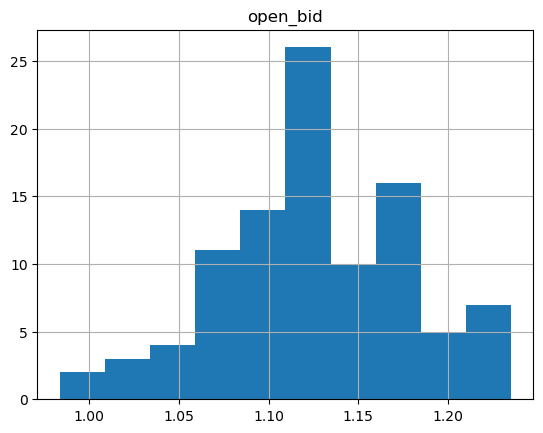

In [12]:
exchange_rate.hist()

<AxesSubplot: xlabel='time'>

<Figure size 1000x900 with 0 Axes>

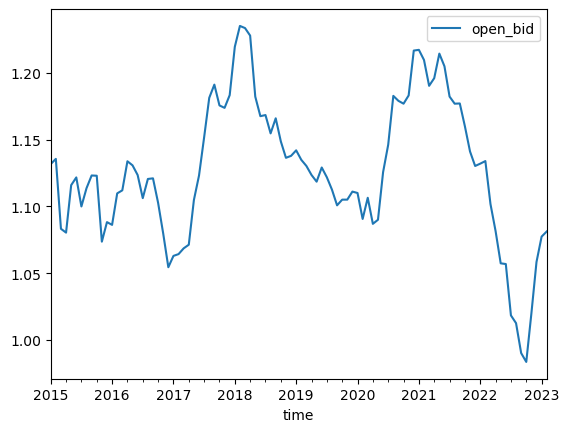

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
exchange_rate.plot()

In [14]:
len(exchange_rate)

98

In [15]:
# Usaremos el 70% de los datos para train y el restante para test. 

training_data, testing_data = train_test_split(exchange_rate, test_size=0.3, random_state=42, shuffle=False)

particion_datos = int(len(exchange_rate)*0.7)
# training_data = list(exchange_rate[0:particion_datos]['open_bid'])
# testing_data = list(exchange_rate[particion_datos:]['open_bid'])
training_data

,open_bid
time,
2015-01-31,1.131713
2015-02-28,1.135614
2015-03-31,1.083278
2015-04-30,1.080416
2015-05-31,1.115950
...,...
2020-04-30,1.086991
2020-05-31,1.090045
2020-06-30,1.125685


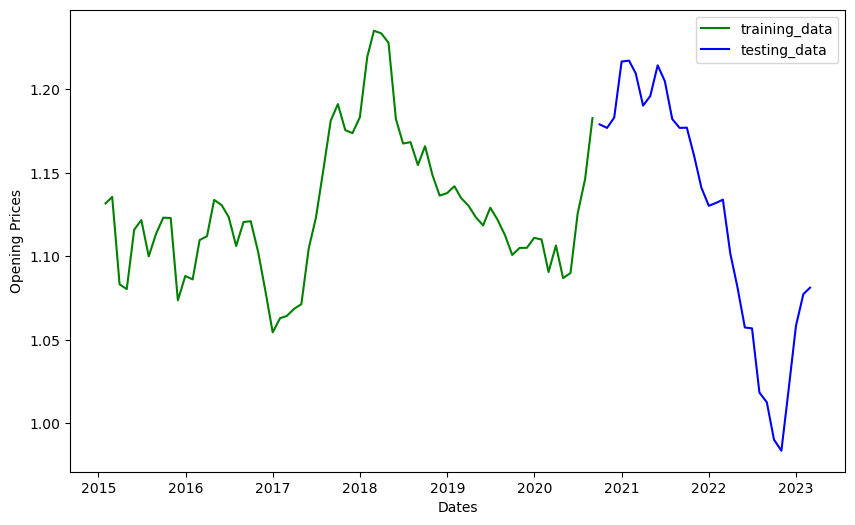

In [16]:
# Para ver gráficamente los datos de train y test

plt.figure(figsize=(10,6))
plt.grid=(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(training_data['open_bid'], 'green', label = 'training_data')
plt.plot(testing_data['open_bid'], 'blue', label = 'testing_data')
plt.legend()

In [17]:
# ARIMA model 
model_predictions = []

n_test_obser = len(testing_data)
n_test_obser

30

In [18]:
test_data = list(testing_data['open_bid'])
train_data = list(training_data['open_bid'])

In [19]:
print(len(test_data))
print(len(train_data))

30
68


In [20]:
# para probar si el modelo funciona con una primera corrida 
for i in range(n_test_obser):
    # Vamos a comenzar con valores de p,d y q
    model = ARIMA(train_data, order = (1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    print(output)
    break

[1.19029972]


## Para elegir p, d y q
* p: The number of lag observations included in the model, also called the lag order. 
* d: The number of times the raw observartion are differenced, also called the degree of differencing. 
* q: The size of the moving average window, also called the order of moving average. 


In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(exchange_rate['open_bid'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.927451
p-value: 0.042248
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


p-value menor a 0.05 significa que la hipótesis nula será rechazada y esta serie puede ser tomada como no estacionaria. 

## Encontrando valor de parámetro "d"

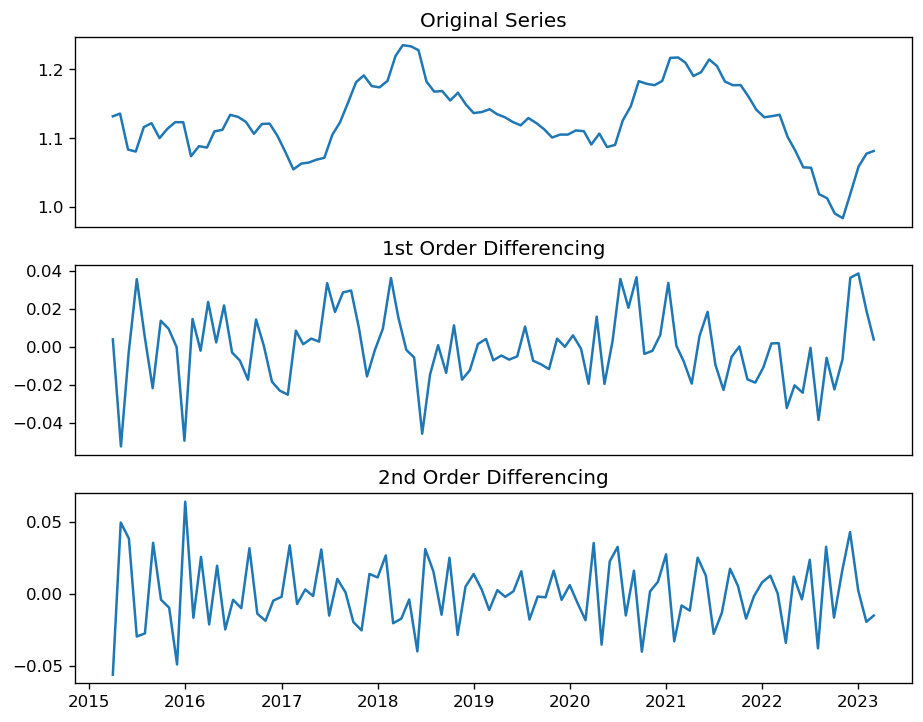

In [23]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(exchange_rate.open_bid); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(exchange_rate.open_bid.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(exchange_rate.open_bid.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

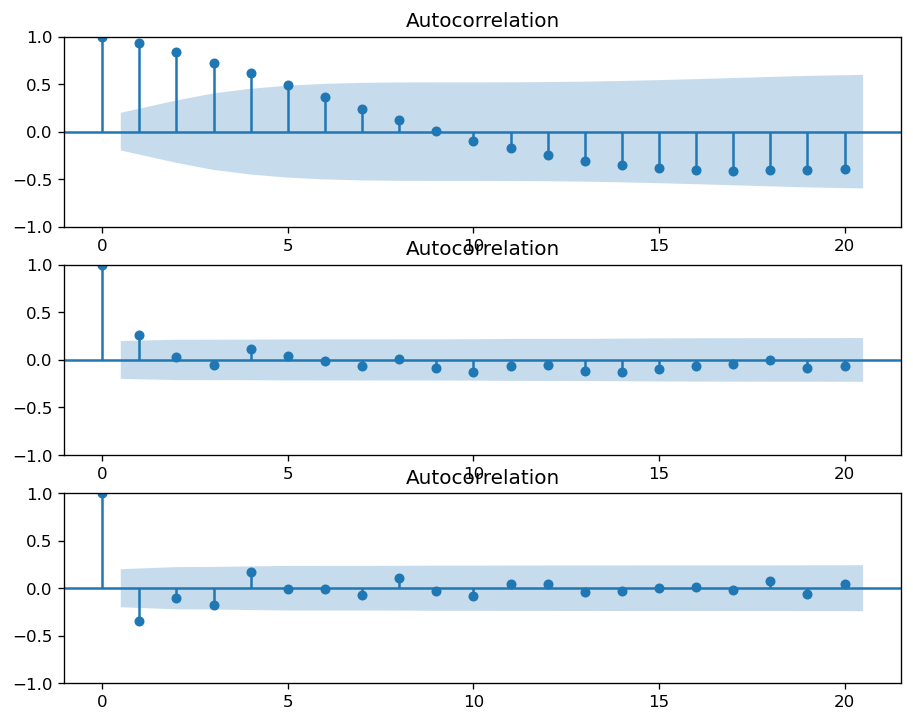

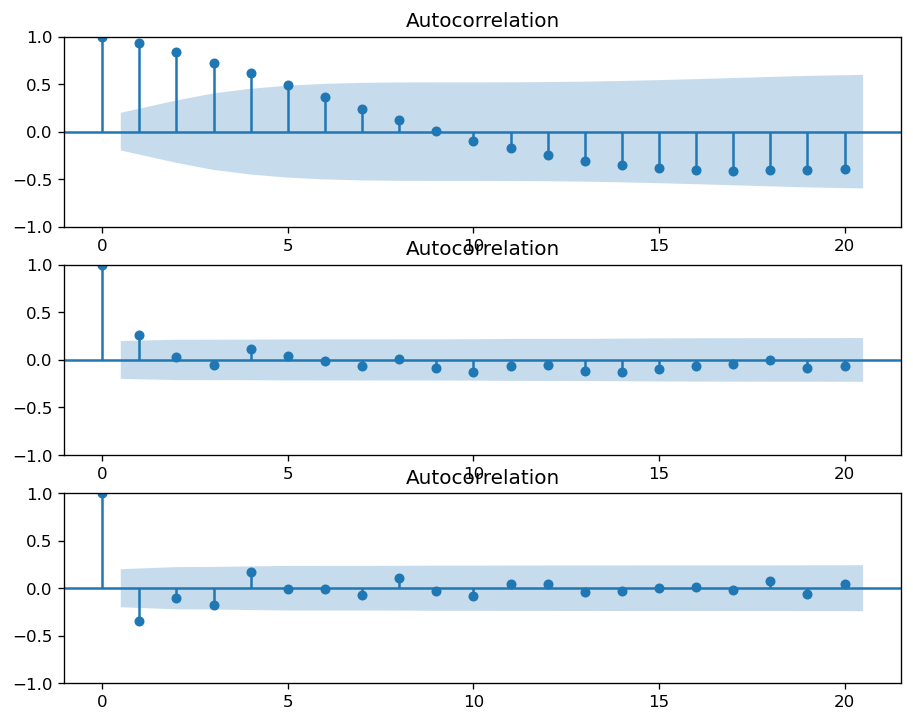

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(exchange_rate.open_bid, ax=ax1)
plot_acf(exchange_rate.open_bid.diff().dropna(), ax=ax2)
plot_acf(exchange_rate.open_bid.diff().diff().dropna(), ax=ax3)

## Encontrando valor de parámetro "p"

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


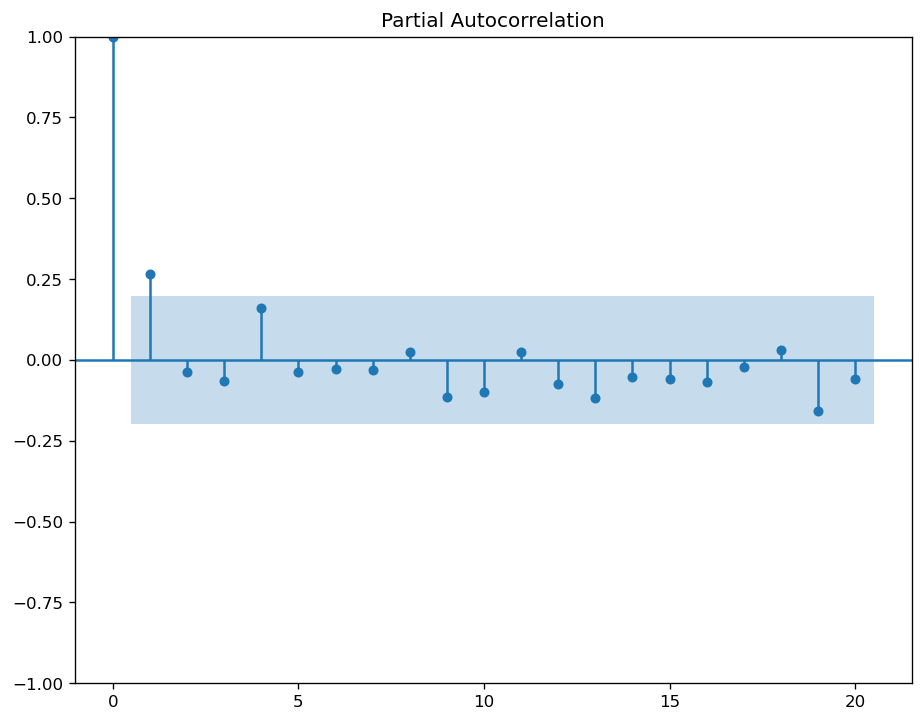

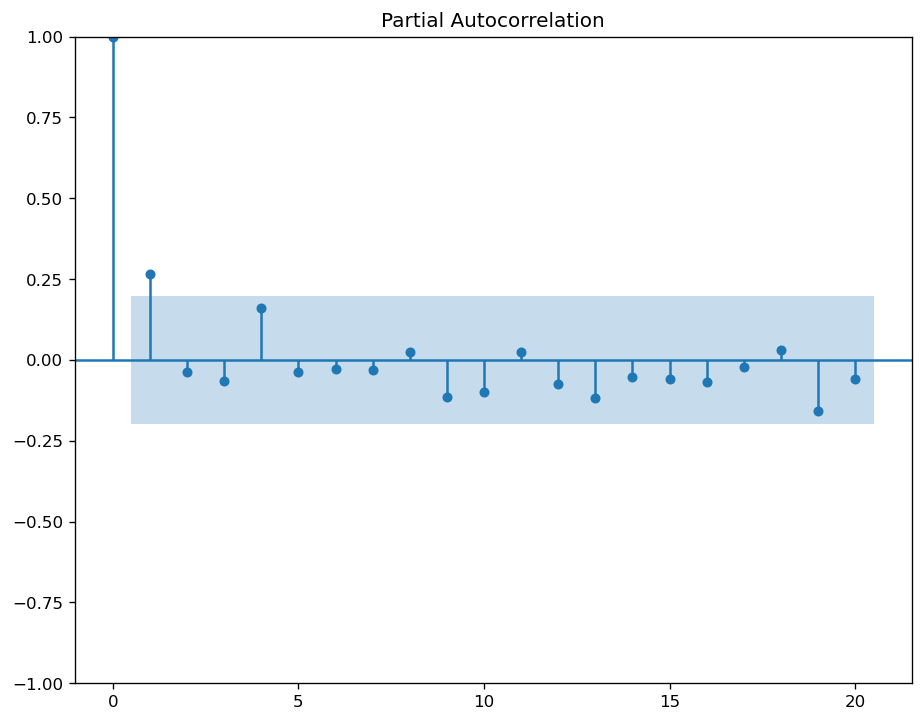

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(exchange_rate.open_bid.diff().dropna())

## Encontrando valor de parámetro "q"

Para encontrar los valores de "q" podemos usar el gráfico de ACF, dicha gráfica nos dice cuanto promedio móvil se requiere para eliminar la autocorrelación de la serie de tiempo estacionaria. 

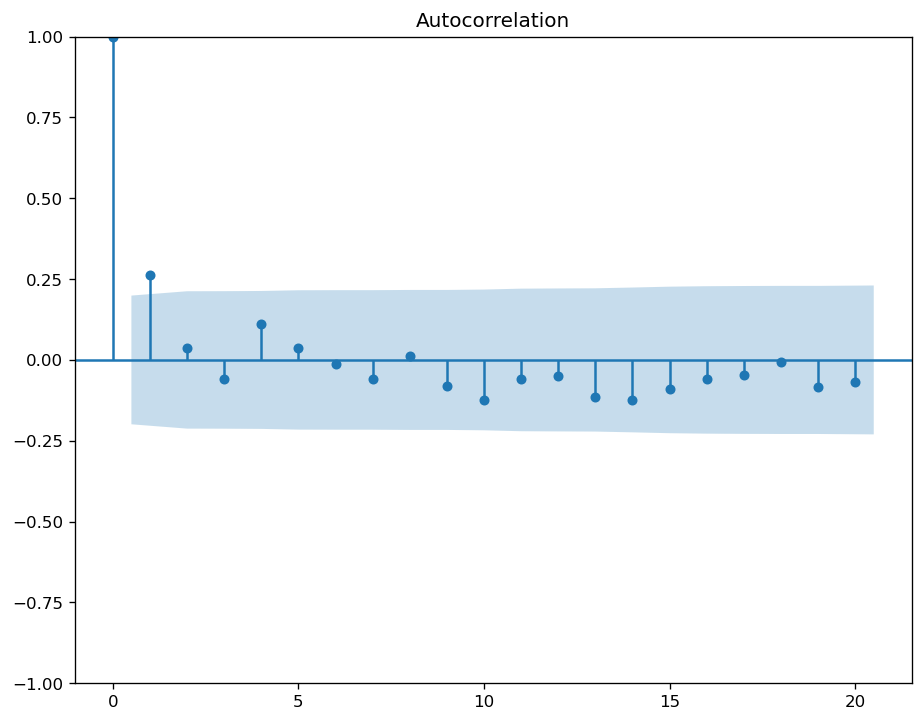

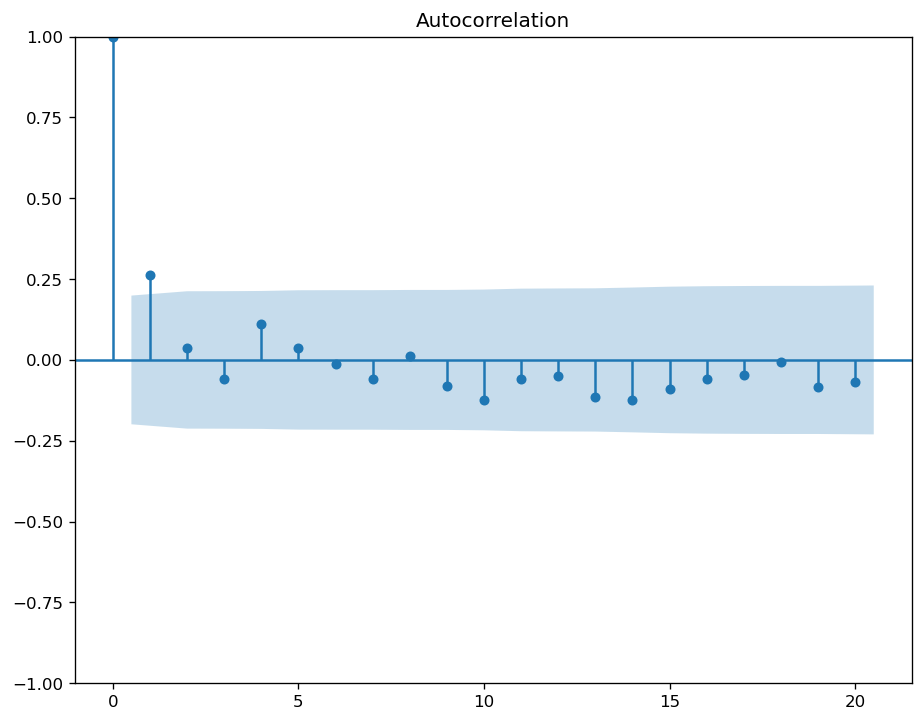

In [26]:
plot_acf(exchange_rate.open_bid.diff().dropna())

Aquí vemos que sólo 1 de los "lags" se encuentra fuera del límite de significancia , por lo que el valor óptimo de "q" es 1. 

In [27]:
# Para construir un iterador que haga las predicciones 
for i in range(n_test_obser):
    # Vamos a comenzar con valores de p,d y q, 
    # Luego podemos usar Auto Arima  model
    model = ARIMA(train_data, order = (1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output
    # print(y_pred)
    model_predictions.append(y_pred)
    # cambiar nombre luego para variable y_actual
    actual_y = test_data[i]
    # Para mantener actualizado el conjunto de train con la data histórica 
    train_data.append(actual_y)

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


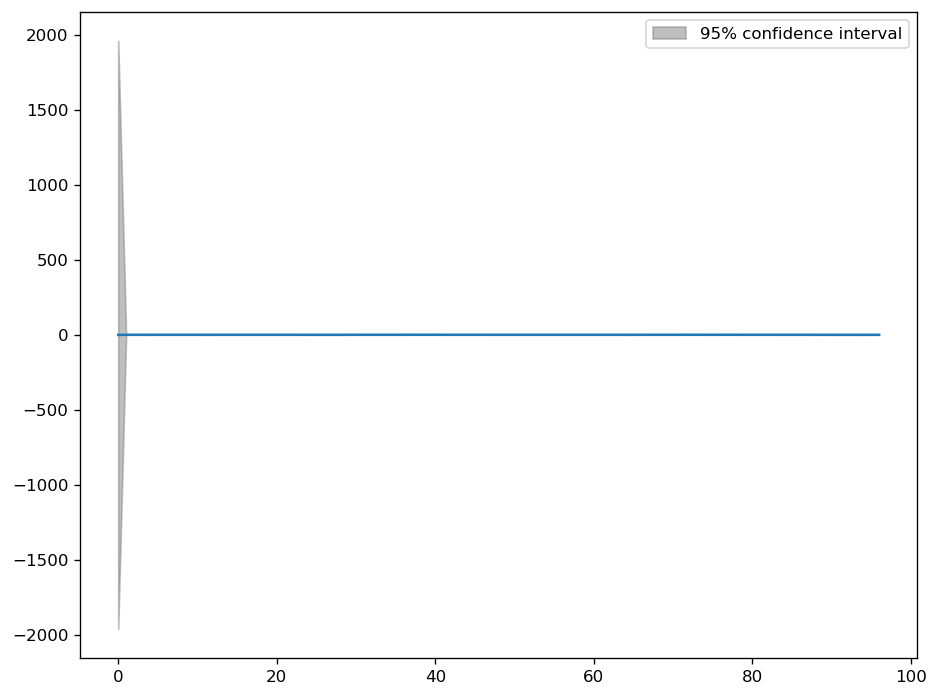

In [ ]:
plot_predict(model_fit, dynamic=False)
plt.show()

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 248.398
Date:                Mon, 20 Mar 2023   AIC                           -490.797
Time:                        22:24:21   BIC                           -483.104
Sample:                             0   HQIC                          -487.687
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1779      0.368      0.483      0.629      -0.544       0.899
ma.L1          0.0915      0.367      0.249      0.803      -0.628       0.811
sigma2         0.0003   4.36e-05      7.591      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.98   Prob(JB):                         0.50
Heteroskedasticity (H):               0.83   Skew:                            -0.21
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
print(len(model_predictions))
print(len(test_data))

30
30


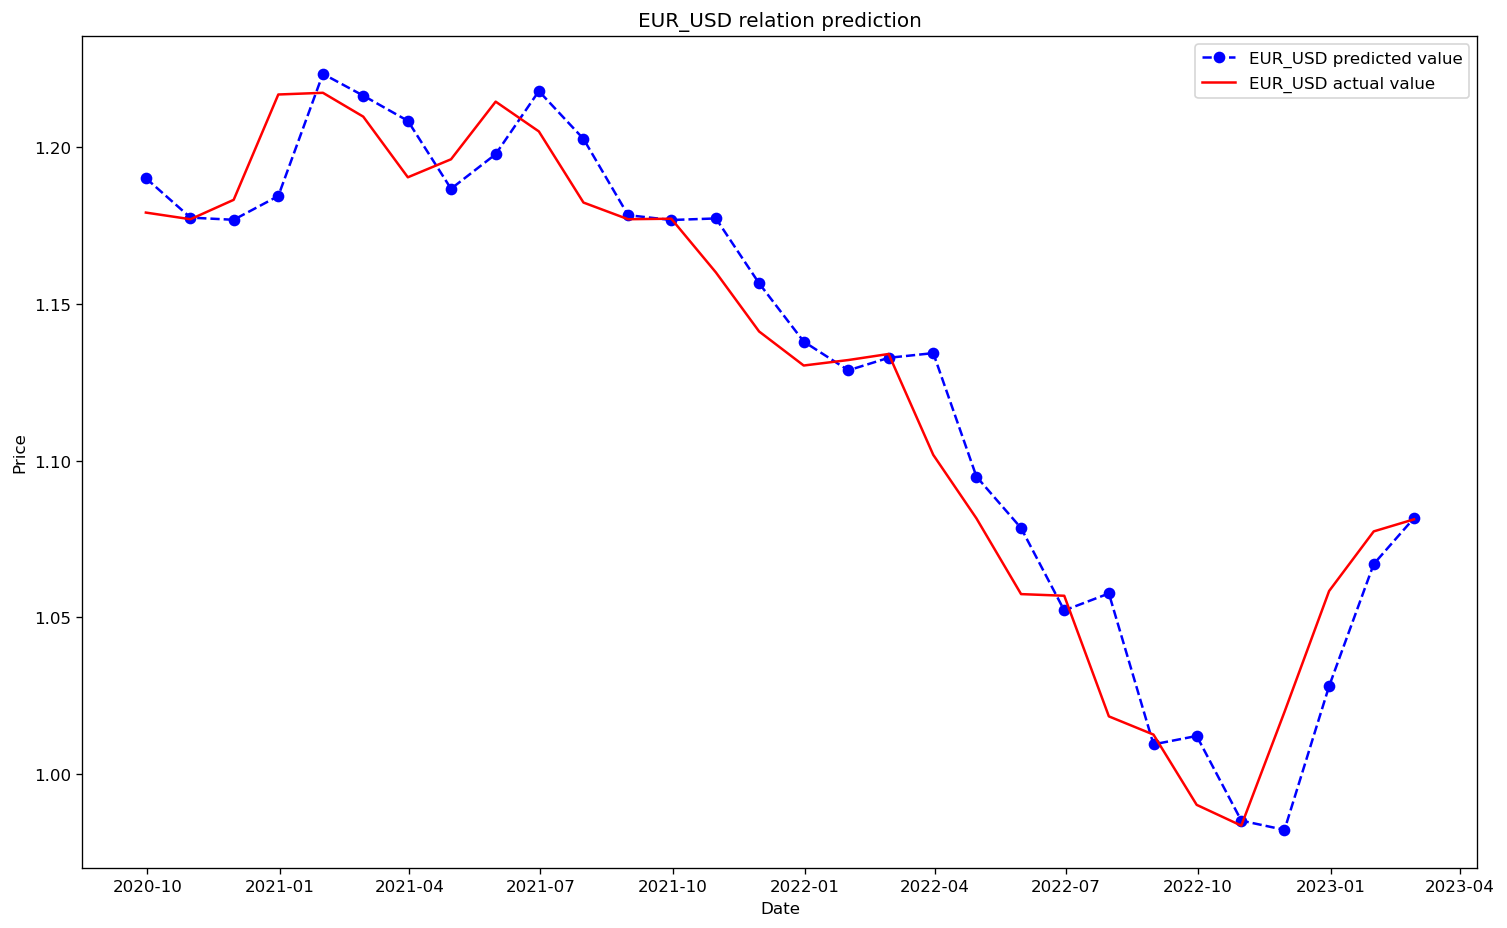

In [30]:
plt.figure(figsize=(15,9))
plt.grid=(True)

date_range = exchange_rate[particion_datos:].index

plt.plot(date_range, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'EUR_USD predicted value')
plt.plot(date_range, test_data, color = 'red', label = 'EUR_USD actual value')

plt.title('EUR_USD relation prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

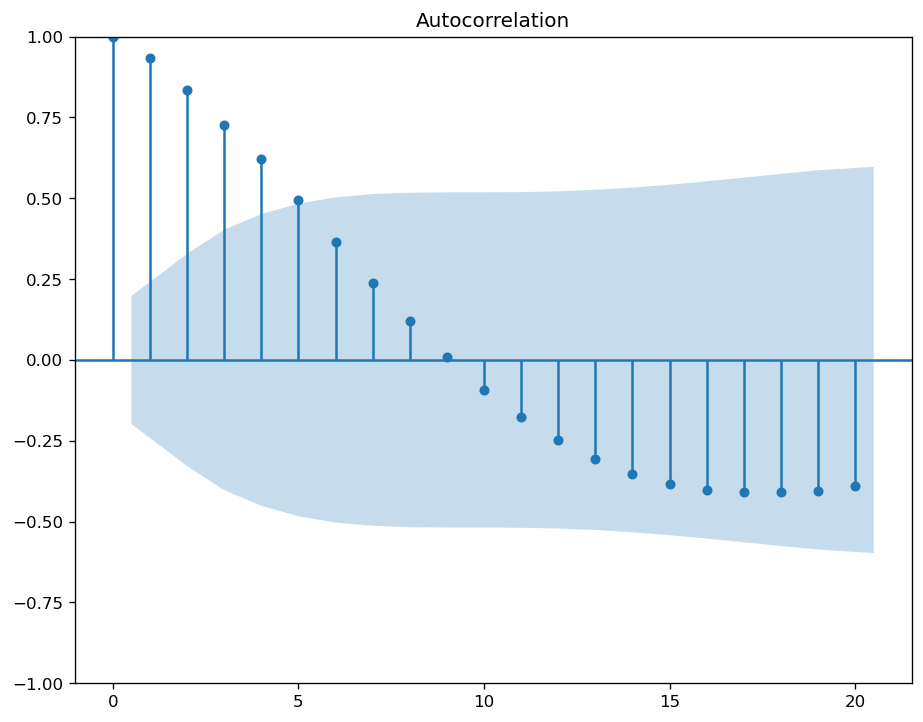

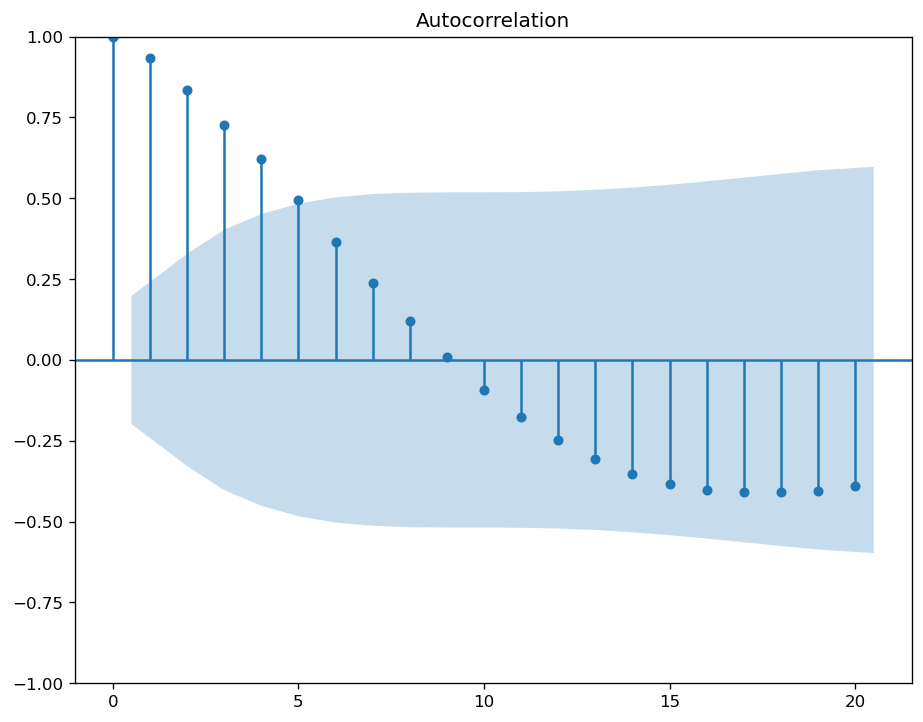

In [31]:
# Para elegir p, d, y q para ARIMA

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(exchange_rate.open_bid)

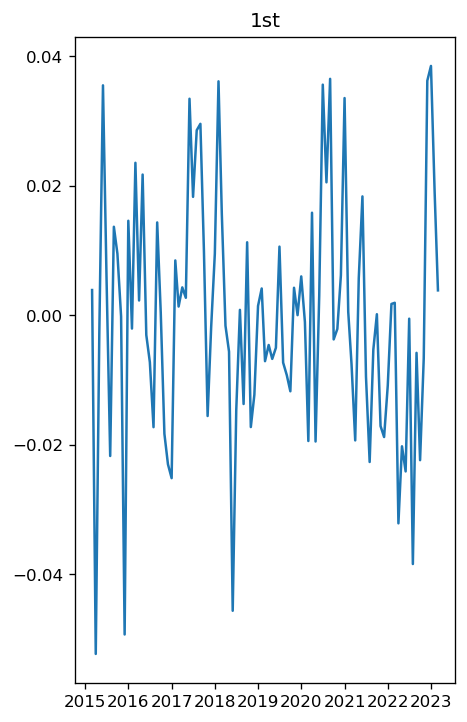

In [32]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st')
ax1.plot(exchange_rate.open_bid.diff())

In [33]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(exchange_rate.open_bid, order = (1,1,2))
model = arima_model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               open_bid   No. Observations:                   98
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 252.513
Date:                Mon, 20 Mar 2023   AIC                           -497.026
Time:                        22:24:23   BIC                           -486.727
Sample:                    01-31-2015   HQIC                          -492.862
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7285      0.387     -1.883      0.060      -1.487       0.030
ma.L1          1.0267      0.354      2.897      0.004       0.332       1.721
ma.L2          0.3089      0.107      2.887      0.0

In [34]:
with open

SyntaxError: expected ':' (2413100560.py, line 1)